## Assignment 3 - Part A - ANN

In [22]:
import sys
from sklearn.datasets import fetch_openml
import pandas as pd
import ssl
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '..')

# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [23]:
ssl._create_default_https_context = ssl._create_unverified_context

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [24]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

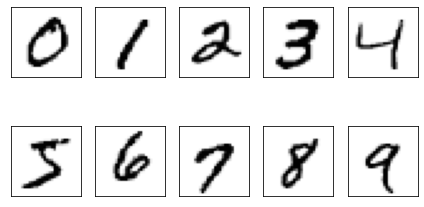

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Split into training, validation, and test set:

In [26]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

print(f"shape of X_test:{X_test.shape}")
print(f"shape of y_test:{y_test.shape}")
print(f"shape of X_train:{X_train.shape}")
print(f"shape of y_train:{y_train.shape}")
print(f"shape of X_valid:{X_valid.shape}")
print(f"shape of y_valid:{y_valid.shape}")

# optional to free up some memory by deleting non-used arrays:
del X, y

shape of X_test:(21000, 784)
shape of y_test:(21000,)
shape of X_train:(44000, 784)
shape of y_train:(44000,)
shape of X_valid:(5000, 784)
shape of y_valid:(5000,)


## Original implementation of one layer perceptron

In [27]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [28]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [29]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [30]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


In [31]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [32]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.2%


In [33]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [34]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.06 | Train Acc: 72.79% | Valid Acc: 72.92%
Epoch: 002/050 | Train MSE: 0.04 | Train Acc: 83.11% | Valid Acc: 82.48%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 86.96% | Valid Acc: 86.20%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.48% | Valid Acc: 88.10%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.45% | Valid Acc: 89.10%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.06% | Valid Acc: 89.64%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.53% | Valid Acc: 90.34%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 90.84% | Valid Acc: 90.66%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.33% | Valid Acc: 90.98%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 91.46% | Valid Acc: 91.24%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 91.67% | Valid Acc: 91.16%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 91.88% | Valid Acc: 91.48%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.23% | Valid Acc: 91.66%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.31

In [35]:
test_mse, test_acc_1_layer_ANN = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc_1_layer_ANN*100:.2f}%')

Test accuracy: 94.28%


Original implementation of one layer perceptron - END

## Implementing a multi-layer perceptron

In [36]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_hidden2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden))
        self.bias_h2 = np.zeros(num_hidden2)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Hidden layer2
        # input dim: [n_examples, n_hidden] dot [n_hidden2, n_hidden].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden2] dot [n_classes, n_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_h2, a_out

    def backward(self, x, a_h, a_h2, a_out, y):
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden2]
        d_z_out__dw_out = a_h2

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden2]
        # output dim: [n_classes, n_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights2
        ## = DeltaOut * dOutNet/dHiddenAct2 * dHiddenAct2/dHiddenNet2 * dHiddenNet2/dWeight2

        # [n_classes, n_hidden2]
        d_z_out__a_h2 = self.weight_out

        # output dim: [n_examples, n_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)

        # [n_examples, n_hidden2]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        delta_h2 = d_loss__a_h2 * d_a_h__d_z_h2

        # [n_examples, n_hidden]
        d_z_h__d_w_h2 = a_h

        # output dim: [n_hidden2, n_hidden]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h__d_z_h2).T, d_z_h__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h__d_z_h2), axis=0)

        #################################        
        # Part 3: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_hidden2, n_hidden]
        d_z_out__a_h = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_h2, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h, d_loss__d_b_h)

In [37]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_hidden2=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [38]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [39]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [40]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [41]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


In [42]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [43]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 20.81% | Valid Acc: 20.74%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 26.82% | Valid Acc: 26.68%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 31.01% | Valid Acc: 30.58%
Epoch: 004/050 | Train MSE: 0.07 | Train Acc: 50.75% | Valid Acc: 50.86%
Epoch: 005/050 | Train MSE: 0.06 | Train Acc: 62.88% | Valid Acc: 63.08%
Epoch: 006/050 | Train MSE: 0.05 | Train Acc: 70.61% | Valid Acc: 70.60%
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 79.21% | Valid Acc: 79.32%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 84.49% | Valid Acc: 84.82%
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 86.76% | Valid Acc: 87.00%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 87.76% | Valid Acc: 87.92%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 88.45% | Valid Acc: 88.42%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.08% | Valid Acc: 88.86%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 89.69% | Valid Acc: 89.58%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.04

In [44]:
test_mse_ANN, test_acc_ANN = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc_ANN*100:.2f}%')

Test accuracy: 94.42%


## ----------------------------------Pytorch Full ANN  start------------------------------------

In [45]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, photos, labels, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_dir = photos
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_dir[idx]
        label = self.img_labels[idx]
        image = torch.from_numpy(image).float()
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [46]:
import torch
import torchvision

n_epochs = 50
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.1
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  CustomImageDataset(X_temp, y_temp),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  CustomImageDataset(X_test, y_test),
  batch_size=batch_size_train, shuffle=True)

In [47]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [48]:
example_data.dtype

torch.float32

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.final = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(self.final(x))
        return F.log_softmax(x)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc_torch = 100. * correct / len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    test_acc_torch))
  return test_acc_torch

In [50]:
test_acc_torch = test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test_acc_torch = test()

C:\Users\shair\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\shair\AppData\Local\Temp/ipykernel_15064/2640556148.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\shair\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3044, Accuracy: 2682/21000 (12.77%)

Train Epoch: 1 [0/49000 (0%)]	Loss: 2.295865
Train Epoch: 1 [1000/49000 (2%)]	Loss: 2.230462
Train Epoch: 1 [2000/49000 (4%)]	Loss: 2.136461
Train Epoch: 1 [3000/49000 (6%)]	Loss: 2.064350
Train Epoch: 1 [4000/49000 (8%)]	Loss: 2.005983
Train Epoch: 1 [5000/49000 (10%)]	Loss: 1.950590
Train Epoch: 1 [6000/49000 (12%)]	Loss: 1.907362
Train Epoch: 1 [7000/49000 (14%)]	Loss: 1.865948
Train Epoch: 1 [8000/49000 (16%)]	Loss: 1.868908
Train Epoch: 1 [9000/49000 (18%)]	Loss: 1.809529
Train Epoch: 1 [10000/49000 (20%)]	Loss: 1.807331
Train Epoch: 1 [11000/49000 (22%)]	Loss: 1.790092
Train Epoch: 1 [12000/49000 (24%)]	Loss: 1.779144
Train Epoch: 1 [13000/49000 (27%)]	Loss: 1.764257
Train Epoch: 1 [14000/49000 (29%)]	Loss: 1.734679
Train Epoch: 1 [15000/49000 (31%)]	Loss: 1.772699
Train Epoch: 1 [16000/49000 (33%)]	Loss: 1.745229
Train Epoch: 1 [17000/49000 (35%)]	Loss: 1.694989
Train Epoch: 1 [18000/49000 (37%)]	Loss: 1.722894
Train E

## ----------------------------------Pytorch Full ANN  end------------------------------------

## Evaluating the neural networks performance

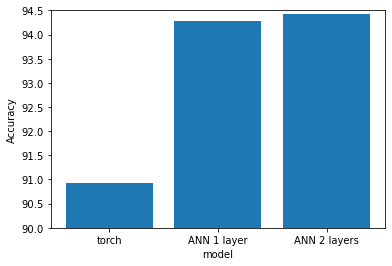

In [58]:
results = [test_acc_torch, test_acc_1_layer_ANN*100, test_acc_ANN*100]
models_names = ["torch", "ANN 1 layer", "ANN 2 layers"]
plt.bar(models_names, results)
plt.ylabel('Accuracy')
plt.xlabel('model')
plt.ylim(90, 94.5)
plt.show()